#### Εισαγωγή Βιβλιοθηκών

In [1]:
import findspark
findspark.init('/home/gioxon/spark-2.2.2-bin-hadoop2.7')

In [2]:
# Spark Session
from pyspark.sql import SparkSession
# Machine Learning Library - Alternating Least Squares
from pyspark.ml.recommendation import ALS
# Συνάρτηση για την εισαγωγή δεδομένων απο csv
from pyspark.sql import Row
# Εκτίμηση ακρίβειας
from pyspark.ml.evaluation import RegressionEvaluator
# Διαχειριση πινάκων
import pandas as pd

#### Δημιουργία Spark Session

In [3]:
spark = SparkSession.builder.appName("MovieRecs").getOrCreate()

#### Διάβασμα Δεδομένων

In [4]:
movies = spark.read.csv('movies.csv',inferSchema=True, sep = ";", header = True)

In [5]:
ratings = spark.read.csv('ratings.csv',inferSchema=True, sep = ",", header = True)

In [6]:
ratings.show(5)
ratings.describe().show()

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      0|     527|   5.0|
|      0|     110|   4.0|
|      0|    2028|   5.0|
|      0|    4011|   4.5|
|      0|   68157|   4.0|
+-------+--------+------+
only showing top 5 rows

+-------+------------------+-----------------+------------------+
|summary|           user_id|         movie_id|            rating|
+-------+------------------+-----------------+------------------+
|  count|          10000030|         10000030|          10000030|
|   mean| 35869.94549226353|4120.313208160375|3.5124212627362117|
| stddev|20585.287060966275|8938.438320174691|1.0604178189562439|
|    min|                 0|                1|               0.5|
|    max|             71567|            68157|               5.0|
+-------+------------------+-----------------+------------------+



In [7]:
movies.show(5)
movies.describe().show()

+--------+--------------------+----+--------------------+
|movie_id|               genre|year|               title|
+--------+--------------------+----+--------------------+
|       1|Adventure|Animati...|1995|         Toy Story  |
|       2|Adventure|Childre...|1995|           Jumanji  |
|       3|      Comedy|Romance|1995|  Grumpier Old Men  |
|       4|Comedy|Drama|Romance|1995| Waiting to Exhale  |
|       5|              Comedy|1995|Father of the Bri...|
+--------+--------------------+----+--------------------+
only showing top 5 rows

+-------+-----------------+------------------+------------------+--------+
|summary|         movie_id|             genre|              year|   title|
+-------+-----------------+------------------+------------------+--------+
|  count|            45656|             45656|             45656|   45656|
|   mean|96350.77742246364|              null|1991.8737296302786|Infinity|
| stddev|57207.69989666748|              null|24.023975471725567|     NaN|
|  

#### Εύρεση των ταινιών με πάνω απο 2000 αξιολογήσεις

In [8]:
ratingCounts = ratings.groupBy("movie_id").count().filter("count > 2000")

#### Δημιουργία dataframe με όλες τις ταινίες με πάνω απο 2000 αξιολογήσεις

In [9]:
df_popular = ratings.join(ratingCounts, 'movie_id', how = 'inner')
df_popular.describe().show()

+-------+------------------+-----------------+------------------+-----------------+
|summary|          movie_id|          user_id|            rating|            count|
+-------+------------------+-----------------+------------------+-----------------+
|  count|           7306383|          7306383|           7306383|          7306383|
|   mean|2500.6446783586352|35869.67406143368|3.6014141333680425|9991.732825257039|
| stddev| 5449.616275564452|20614.79828152954|1.0305155927872907|7549.053774165623|
|    min|                 1|                0|               0.5|             2002|
|    max|             59315|            71567|               5.0|            34865|
+-------+------------------+-----------------+------------------+-----------------+



#### Διαχωρισμός δεδομένων σε training - test

In [10]:
(training, test) = df_popular.randomSplit([0.7, 0.3])

#### Βρόγχος για τον υπολογισμό του RMSE με διαφορετικό αριθμό επαναλήψεων

In [11]:
iter_rmse_dict = dict()
def als_model(iter_number):
    for i in range(1, iter_number + 1):
        als = ALS(maxIter=i, userCol="user_id", itemCol="movie_id", ratingCol="rating"
                  ,coldStartStrategy="drop")
        model = als.fit(training)
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        iter_rmse_dict[i] = (rmse)
        print("Iterations= " + str(i) + ", RMSE= " + str(rmse))

#### Εφαρμογή βρόγχου για 20 επαναλήψεις

In [12]:
als_model(20)

Iterations= 1, RMSE= 3.2616822361842117
Iterations= 2, RMSE= 0.9227840887717059
Iterations= 3, RMSE= 0.8686096187451091
Iterations= 4, RMSE= 0.8497370480454397
Iterations= 5, RMSE= 0.8381558076000963
Iterations= 6, RMSE= 0.8308740404289506
Iterations= 7, RMSE= 0.826010785574595
Iterations= 8, RMSE= 0.8225250117224238
Iterations= 9, RMSE= 0.8199239721496571
Iterations= 10, RMSE= 0.8179447555929767
Iterations= 11, RMSE= 0.8164153225148799
Iterations= 12, RMSE= 0.8152129953889956
Iterations= 13, RMSE= 0.8142512234182436
Iterations= 14, RMSE= 0.8134697808307957
Iterations= 15, RMSE= 0.8128264122863814
Iterations= 16, RMSE= 0.8122908260350994
Iterations= 17, RMSE= 0.8118407706913289
Iterations= 18, RMSE= 0.8114595399450826
Iterations= 19, RMSE= 0.8111343506902298
Iterations= 20, RMSE= 0.8108552663397768


#### Aποθήκευση και γράφημα

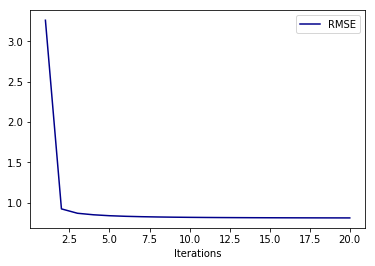

In [24]:
iter_rmse = pd.DataFrame(list(iter_rmse_dict.items()), columns=['Iterations', 'RMSE'])
iter_rmse.plot.line(x='Iterations', y= 'RMSE', c = 'DarkBlue')

#### Εφαρμογή του μοντέλου ALS collaborative filtering model στα δεδομένα


In [14]:
als = ALS(maxIter=20, userCol="user_id", itemCol="movie_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

#### Πρόβλεψη του μοντέλου

In [16]:
predictions = model.transform(test)

#### Εκτίμηση ακρίβειας με υπολογισμό της Ρίζας της μέσης τετραγωνικής απόκλισης - RMSE

In [17]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8108552663397768


#### Υπολογισμός 10 προτεινόμενων ταινιών για κάθε χρήστη

In [45]:
userRecs = model.recommendForAllUsers(10)

#### Εμφάνιση των ταινιών που εισάγαμε (user_id = 0)

In [26]:
user_id_0 = ratings.filter(ratings['user_id']==0).select(
    ['movie_id', 'user_id', 'rating'])
user_id_0.join(movies, on = 'movie_id', how = 'inner')[[
    'user_id', 'movie_id', 'title', 'rating']].show()

+-------+--------+--------------------+------+
|user_id|movie_id|               title|rating|
+-------+--------+--------------------+------+
|      0|     527|  Schindler's List  |   5.0|
|      0|     110|        Braveheart  |   4.0|
|      0|    2028|Saving Private Ry...|   5.0|
|      0|    4011|            Snatch  |   4.5|
|      0|   68157|Inglourious Baste...|   4.0|
|      0|     356|      Forrest Gump  |   5.0|
+-------+--------+--------------------+------+



#### Μετατροπή Spark dataframe ταινιών σε Pandas Dataframe

In [ ]:
df_movies = movies.toPandas()
df_movies.drop(['genre', 'year'], inplace=True, axis = 1)

#### Εμφάνιση 10 προτεινόμενων ταινιών για τον χρήστη  user_id = 0

In [46]:
# Αποθήκευση αποτελεσμάτων σε list
user_0 = userRecs[userRecs['user_id']==0].select(['recommendations']).collect()

In [47]:
# Μετατροπή σε Dataframe
user_0 = pd.DataFrame(user_0, columns=['movie_id-rating'])
user_0 = pd.DataFrame(user_0['movie_id-rating'][0], columns=['movie_id', 'rating'])

In [48]:
# Εμφάνιση αποτελεσμάτων με τα ονόματα της ταινίας
results = pd.merge(df_movies, user_0, on = 'movie_id', how = 'inner')
results.sort_values('rating', ascending=False)

,movie_id,title,rating
1,318,Shawshank Redemption,4.907811
3,527,Schindler's List,4.876192
5,858,Godfather,4.797772
9,2324,Life Is Beautiful La Vita è bella,4.664038
6,1193,One Flew Over the Cuckoo's Nest,4.656334
0,50,Usual Suspects,4.620875
2,356,Forrest Gump,4.606669
7,1221,Godfather: Part II,4.598062
8,2028,Saving Private Ryan,4.592341
4,593,Silence of the Lambs,4.590737


#### Εμφάνιση των ταινιών που εισάγαμε (user_id = 1)

In [49]:
user_id_1 = ratings.filter(ratings['user_id']==1).select(
    ['movie_id', 'user_id', 'rating'])
user_id_1.join(movies, on = 'movie_id', how = 'inner')[[
    'user_id', 'movie_id', 'title', 'rating']].show()

+-------+--------+--------------------+------+
|user_id|movie_id|               title|rating|
+-------+--------+--------------------+------+
|      1|    2840|          Stigmata  |   4.0|
|      1|      47|Seven a.k.a. Se7e...|   5.0|
|      1|    5219|     Resident Evil  |   4.0|
|      1|     593|Silence of the Lambs|   5.0|
|      1|     296|      Pulp Fiction  |   4.5|
|      1|    1645|The Devil's Advoc...|   4.0|
+-------+--------+--------------------+------+



#### Εμφάνιση 10 προτεινόμενων ταινιών για τον χρήστη  user_id = 1

In [50]:
# Αποθήκευση αποτελεσμάτων σε list
user_1 = userRecs[userRecs['user_id']==1].select(['recommendations']).collect()

In [51]:
# Μετατροπή σε Dataframe
user_1 = pd.DataFrame(user_1, columns=['movie_id-rating'])
user_1 = pd.DataFrame(user_1['movie_id-rating'][0], columns=['movie_id', 'rating'])

In [52]:
# Εμφάνιση αποτελεσμάτων με τα ονόματα της ταινίας
results = pd.merge(df_movies, user_1, on = 'movie_id', how = 'inner')
results.sort_values('rating', ascending=False)

,movie_id,title,rating
5,2571,Matrix,4.827216
3,318,Shawshank Redemption,4.764733
9,58559,Dark Knight,4.739077
6,2959,Fight Club,4.735715
1,50,Usual Suspects,4.712737
4,593,Silence of the Lambs,4.700109
0,47,Seven a.k.a. Se7en,4.687925
2,296,Pulp Fiction,4.666629
8,7153,Lord of the Rings: The Return of the King,4.661360
7,4993,Lord of the Rings: The Fellowship of the Ring,4.652792


#### Εμφάνιση των ταινιών που εισάγαμε (user_id = 2)

In [53]:
user_id_2 = ratings.filter(ratings['user_id']==2).select(
    ['movie_id', 'user_id', 'rating'])
user_id_2.join(movies, on = 'movie_id', how = 'inner')[[
    'user_id', 'movie_id', 'title', 'rating']].show()

+-------+--------+--------------------+------+
|user_id|movie_id|               title|rating|
+-------+--------+--------------------+------+
|      2|    6934|  Matrix Revolutions|   5.0|
|      2|    6365|     Matrix Reloaded|   4.5|
|      2|    2571|              Matrix|   5.0|
|      2|    2628|Star Wars: Episod...|   5.0|
|      2|    5378|Star Wars: Episod...|   5.0|
|      2|   33493|Star Wars: Episod...|   4.5|
+-------+--------+--------------------+------+



#### Εμφάνιση 10 προτεινόμενων ταινιών για τον χρήστη  user_id = 2

In [54]:
# Αποθήκευση αποτελεσμάτων σε list
user_2 = userRecs[userRecs['user_id']==2].select(['recommendations']).collect()

In [55]:
# Μετατροπή σε Dataframe
user_2 = pd.DataFrame(user_2, columns=['movie_id-rating'])
user_2 = pd.DataFrame(user_2['movie_id-rating'][0], columns=['movie_id', 'rating'])

In [56]:
# Εμφάνιση αποτελεσμάτων με τα ονόματα της ταινίας
results = pd.merge(df_movies, user_2, on = 'movie_id', how = 'inner')
results.sort_values('rating', ascending=False)

,movie_id,title,rating
6,7153,Lord of the Rings: The Return of the King,5.191814
5,5952,Lord of the Rings: The Two Towers,5.148344
4,4993,Lord of the Rings: The Fellowship of the Ring,5.122734
2,2571,Matrix,5.083700
3,3578,Gladiator,5.003255
7,33493,Star Wars: Episode III - Revenge of the Sith,4.921426
9,58559,Dark Knight,4.904119
8,51662,300,4.874289
0,110,Braveheart,4.864000
1,1210,Star Wars: Episode VI - Return of the Jedi,4.863513


#### Τερματισμός Session

In [23]:
spark.stop()